In [1]:
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn as sns


In [2]:
# Find common transformers along 3 phases

df = pd.DataFrame([])
for name in ['Jan','Feb','Mar','Apr','May']:
    tmp = pd.read_excel('HEDNO_overpwr_'+name+'_2024.xlsx', engine='openpyxl')
    tmp = tmp.loc[(tmp['Nr. of power alarms L1']+ tmp['Nr. of power alarms L2'] + tmp['Nr. of power alarms L3'])>0]
    df = pd.concat([df,tmp])
common_transformers  = list(df['Transformer'].unique())
common_transformers 

['ΜΜ-423',
 'ΜΠ-297',
 'ΜΠ-013',
 'ΜΠ-112',
 'ΜΠ-110',
 'MM-185',
 'ΜΝ-010',
 'ΜΤ-055',
 'MM-359',
 'ΜΠ-046',
 'ΜΠ-004',
 'ΜΠ-017',
 'ΜΡ-093']

   Transformer  Nr. of power alarms L1  Avg duration of power alarms L1 (min)  \
0       ΜΜ-423                       6                                   1.17   
1       ΜΠ-297                      64                                   3.61   
2       ΜΠ-013                     699                                  22.91   
15      ΜΠ-110                      21                                   3.24   
19      MM-185                     218                                   7.50   
20      ΜΝ-010                      63                                   4.89   
27      ΜΤ-055                       2                                   2.50   
29      MM-359                       5                                  34.20   
31      ΜΠ-046                       5                                   1.40   
36      ΜΠ-004                     659                                  11.46   

    Avg % of exceeding threshold L1  % of time L1     month  
0                             84.71           

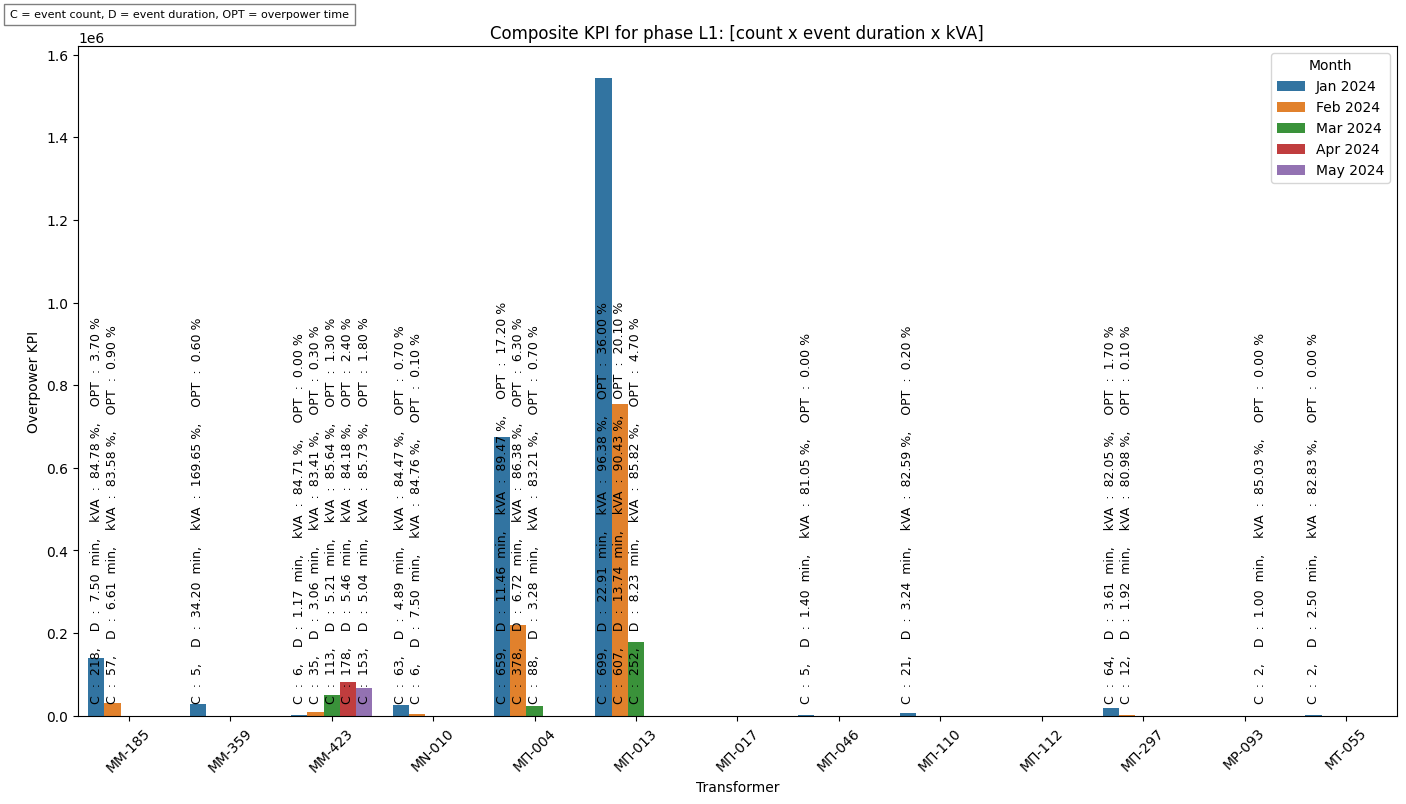

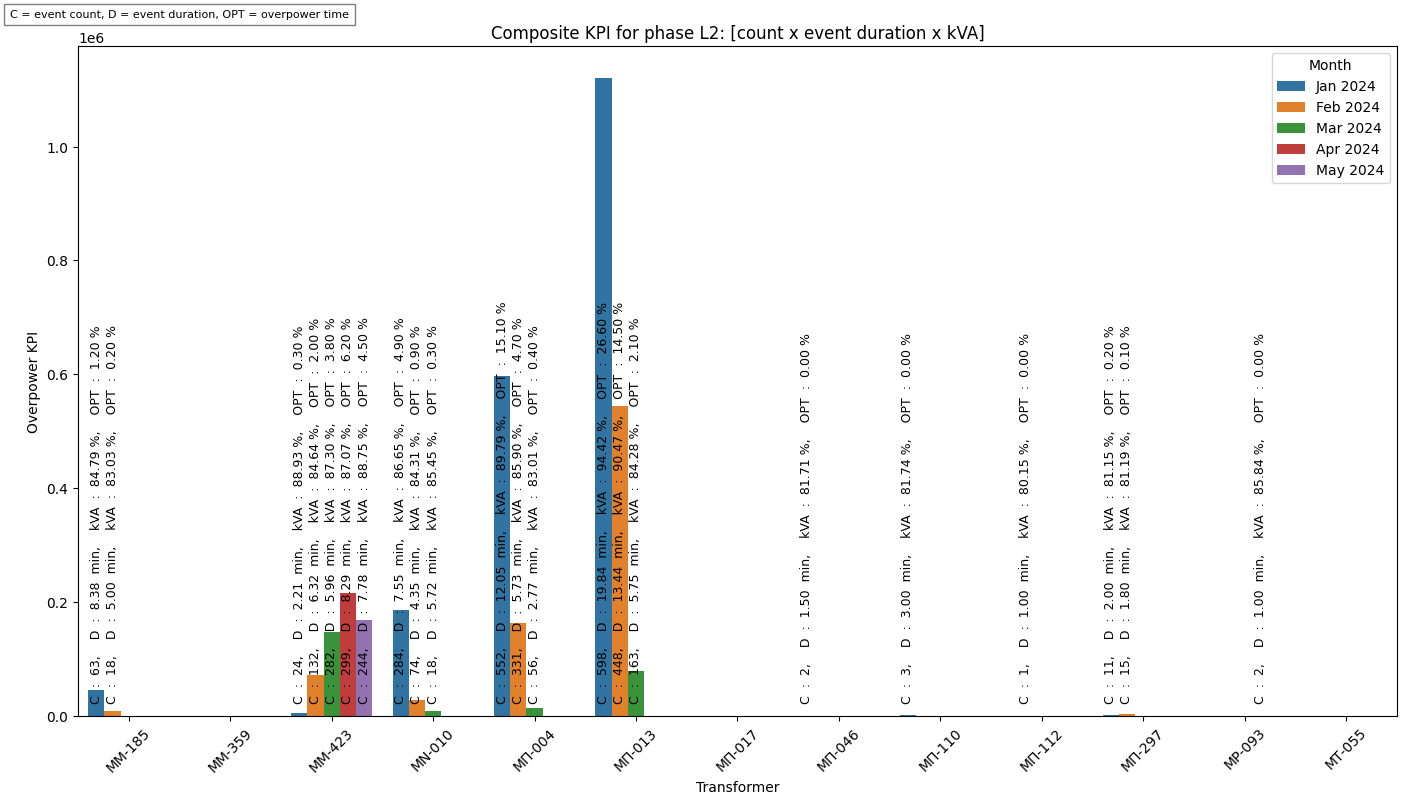

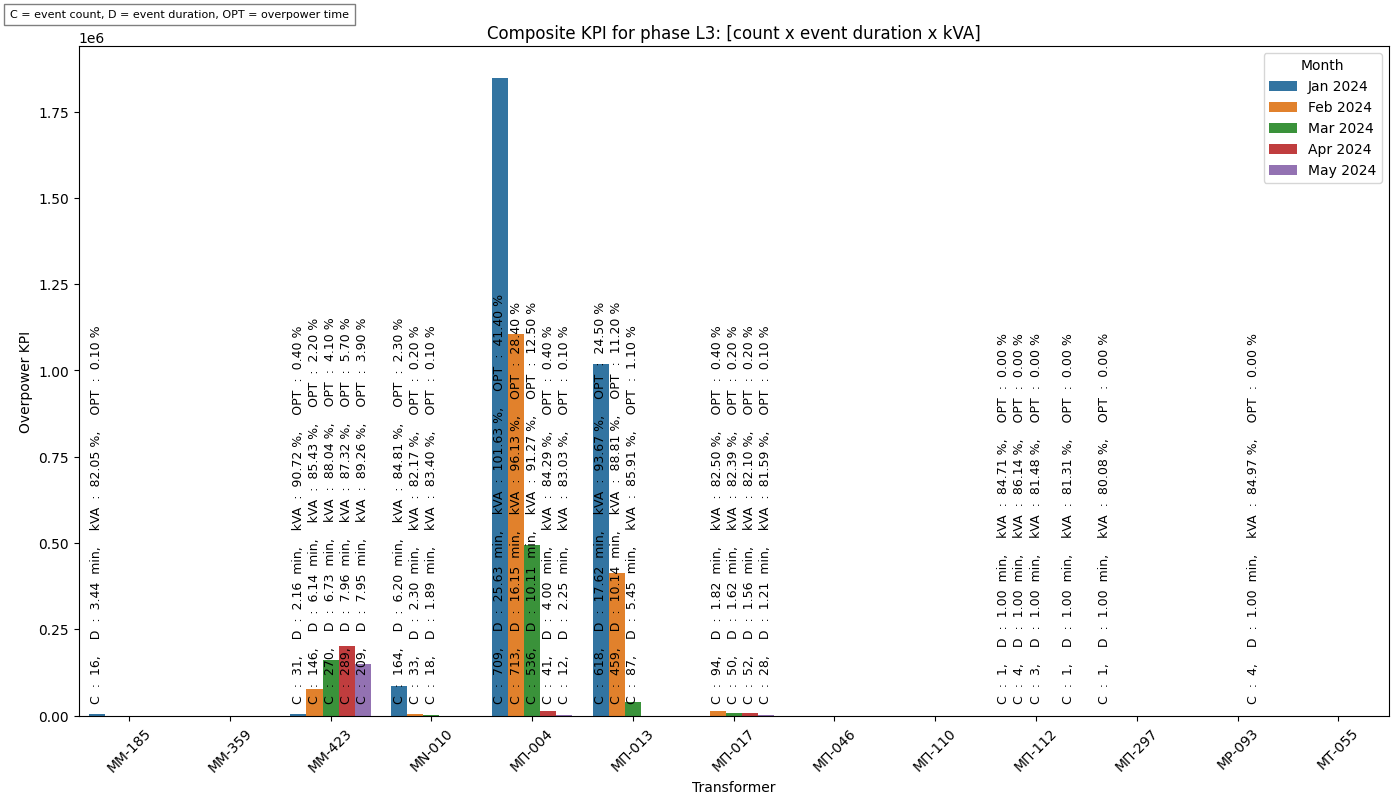

In [3]:

def plotfig(df, ph):
    # 2D plot
    fig = plt.figure(figsize=(14, 8))
    
    barplot = sns.barplot(data=df, x='Transformer', y='Overpower KPI', hue='month')
   
    # Set plot labels and title
    plt.xlabel('Transformer')
    plt.ylabel('Overpower KPI')
    plt.title('Composite KPI for phase ' + ph + ': [count x event duration x kVA]')
    plt.xticks(rotation=45)
    plt.legend(title='Month')
    plt.tight_layout()


    # Add text box inside the figure
    textstr = 'C = event count, D = event duration, OPT = overpower time'
    plt.text(0.5, max(df['Overpower KPI']) * 1.1, textstr, fontsize=8,
             verticalalignment='center', horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.5), transform=plt.gca().transData)


    
    for p in barplot.patches:
        height = p.get_height()
        if height > 0:  # Only annotate bars with a height greater than 0
            # Get the index of the bar in the plot
            bar_index = barplot.patches.index(p)
            # Find the corresponding row in the DataFrame
            row = df.iloc[bar_index]
            print(row)
            # Extract the values for the annotation
            nr_power_alarms = row['Nr. of power alarms ' + ph]
            avg_duration = row['Avg duration of power alarms ' + ph + ' (min)']
            avg_excess = row['Avg % of exceeding threshold ' + ph]
            timeperc = row['% of time ' + ph]
            # Create the annotation label
            label = f'   C  :  {nr_power_alarms},    D  :  {avg_duration:.2f}  min,    kVA  :  {avg_excess:.2f} %,    OPT  :  {timeperc:.2f} %'
            # Annotate the bar
            barplot.text(p.get_x() + p.get_width() / 2., 0,
                         label, ha='center', va='bottom', rotation=90, fontsize=9, color='black')

    # Show the plot
    plt.savefig('PowerKPI_phase'+ph+'.png', dpi=300)
    # plt.show()

custom_dict = {'Jan 2024':0,'Feb 2024':1, 'Mar 2024':2, 'Apr 2024':3, 'May 2024':4}
set1 = set(common_transformers)
months = ['Jan 2024', 'Feb 2024', 'Mar 2024', 'Apr 2024', 'May 2024']  # Replace with your actual list of months
for ph in ['L1', 'L2', 'L3']:
    df = pd.DataFrame([])
    

    for name in ['Jan', 'Feb', 'Mar', 'Apr', 'May']:
        tmp = pd.read_excel('HEDNO_overpwr_' + name + '_2024.xlsx', engine='openpyxl')
        tmp = tmp.loc[tmp['Nr. of power alarms ' + ph] > 0]
        summary = tmp.copy()
        summary = summary[['Transformer', 'Nr. of power alarms ' + ph,
                           'Avg duration of power alarms ' + ph + ' (min)',
                           'Avg % of exceeding threshold ' + ph, '% of time ' + ph]]
        
        
        summary['Nr. of power alarms ' + ph] = summary['Nr. of power alarms ' + ph].astype(int)
        summary = summary.round({'Avg duration of power alarms ' + ph + ' (min)': 2,
                                 'Avg % of exceeding threshold ' + ph: 2})

        summary['month'] = name + ' 2024'
        print(summary)
        # Merge with the common_df to ensure all transformers are included
        set2 = set(list(summary['Transformer'].unique()))
        # Find non-common elements using symmetric difference
        missing_transf = list(set1.symmetric_difference(set2))
        # Create a DataFrame with all combinations of transformers and months
        common_df = pd.DataFrame([t for t in missing_transf], columns=['Transformer'])
        common_df['month'] = name + ' 2024'
        common_df['Nr. of power alarms ' + ph] = 0
        common_df['Avg duration of power alarms ' + ph + ' (min)'] = 0.0
        common_df['Avg % of exceeding threshold ' + ph] = 0.0
        common_df['% of time ' + ph] = 0.0
        summary = pd.concat([summary,common_df])

        df = pd.concat([df, summary])
    

    # print(df)
    df['Overpower KPI'] = df['Nr. of power alarms ' + ph] * df['Avg % of exceeding threshold ' + ph] * df['Avg duration of power alarms ' + ph + ' (min)']
    df = df.round({'Overpower KPI': 2})

    # Map the custom order to the second column
    df['custom'] = df['month'].map(custom_dict)
    # Sort the DataFrame by the first column ascending and the custom order of the second column
    df = df.sort_values(by=['custom','Transformer'])
    # Drop the auxiliary column used for sorting
    df = df.drop(columns=['custom'])
    # df.to_excel('phase'+ph+'.xlsx', index=False)
    plotfig(df, ph)

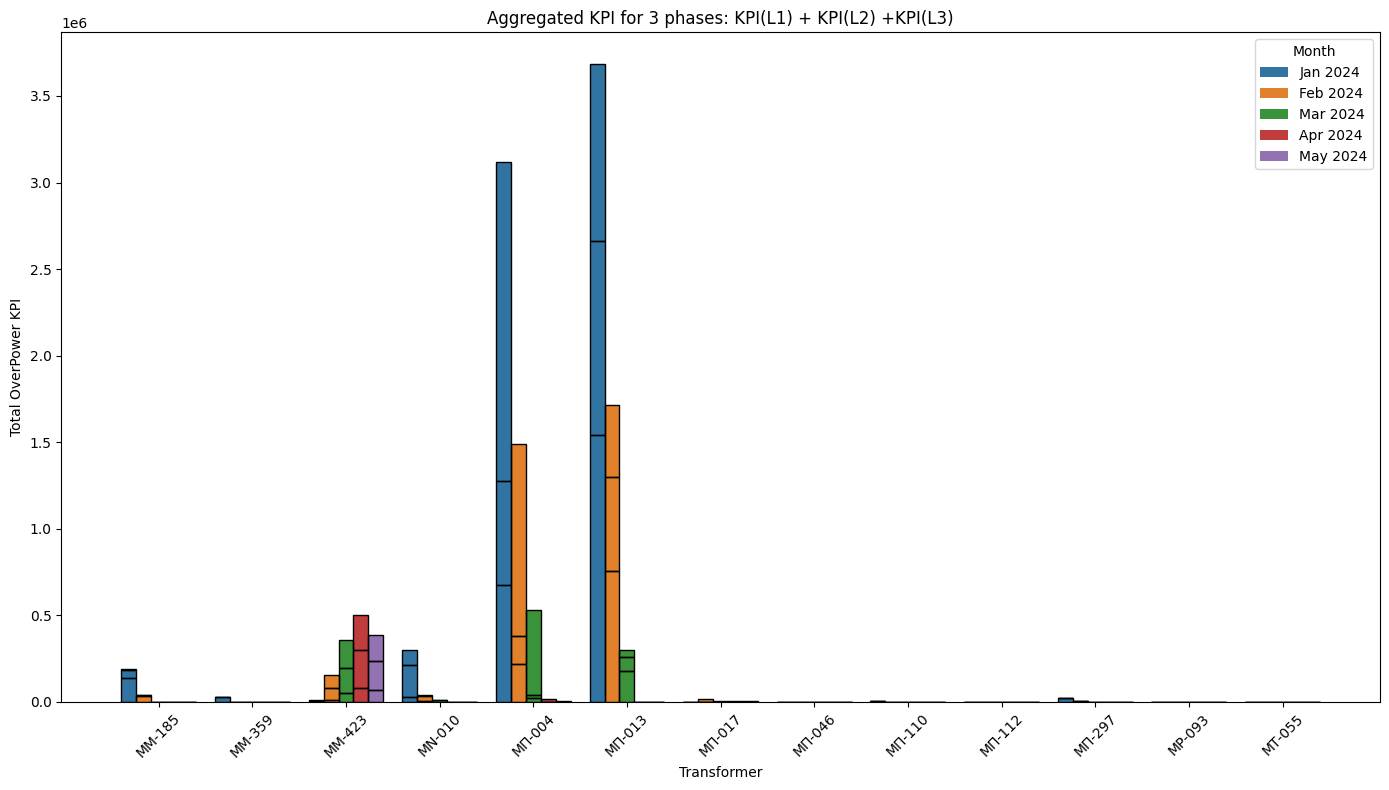

In [4]:

# Create a plot with combined KPI of 3 phases


def plotaggfig(df):
    # 2D plot
    # fig = plt.figure(figsize=(14, 8))
    fig, ax = plt.subplots(figsize=(14, 8))

    barplot = sns.barplot(data=df, x='Transformer', y='Total OverPower KPI', hue='month',dodge=True, ax=ax)
    bar_width = barplot.patches[0].get_width()
    # Get the positions of the bars
    positions = []
    for bar in barplot.patches:
        positions.append(bar.get_x() + bar_width/ 2)

    # Remove duplicate positions (one per transformer per month)
    unique_positions = list(dict.fromkeys(positions))
    df = df.reset_index()
    # Overlay the segments for each transformer and month
    for i, (transformer, month) in enumerate(zip(df['Transformer'], df['month'])):
        bottom = 0
        for phase in ['Overpower KPI L1','Overpower KPI L2','Overpower KPI L3']:
            height = df[phase][i]
            ax.bar(unique_positions[i], height, bottom=bottom, color='none', edgecolor='black',width=bar_width)
            bottom += height


    # Set plot labels and title
    plt.xlabel('Transformer')
    plt.ylabel('Total OverPower KPI')
    plt.title('Aggregated KPI for 3 phases: KPI(L1) + KPI(L2) +KPI(L3)')
    plt.xticks(rotation=45)
    plt.legend(title='Month')
    plt.tight_layout()


    # Show the plot
    plt.savefig('AggPowerKPI.png', dpi=300)
    #plt.show()

kpisdf = pd.DataFrame([])
custom_dict = {'Jan 2024':0,'Feb 2024':1, 'Mar 2024':2, 'Apr 2024':3, 'May 2024':4}
set1 = set(common_transformers)
months = ['Jan 2024', 'Feb 2024', 'Mar 2024', 'Apr 2024', 'May 2024']  # Replace with your actual list of months
for ph in ['L1', 'L2', 'L3']:
    df = pd.DataFrame([])
    

    for name in ['Jan', 'Feb', 'Mar', 'Apr', 'May']:
        tmp = pd.read_excel('HEDNO_overpwr_' + name + '_2024.xlsx', engine='openpyxl')
        tmp = tmp.loc[tmp['Nr. of power alarms ' + ph] > 0]
        summary = tmp.copy()
        summary = summary[['Transformer', 'Nr. of power alarms ' + ph,
                           'Avg duration of power alarms ' + ph + ' (min)',
                           'Avg % of exceeding threshold ' + ph, '% of time ' + ph]]
        
        
        summary['Nr. of power alarms ' + ph] = summary['Nr. of power alarms ' + ph].astype(int)
        summary = summary.round({'Avg duration of power alarms ' + ph + ' (min)': 2,
                                 'Avg % of exceeding threshold ' + ph: 2})

        summary['month'] = name + ' 2024'
        # Merge with the common_df to ensure all transformers are included
        set2 = set(list(summary['Transformer'].unique()))
        # Find non-common elements using symmetric difference
        missing_transf = list(set1.symmetric_difference(set2))
        # Create a DataFrame with all combinations of transformers and months
        common_df = pd.DataFrame([t for t in missing_transf], columns=['Transformer'])
        common_df['month'] = name + ' 2024'
        common_df['Nr. of power alarms ' + ph] = 0
        common_df['Avg duration of power alarms ' + ph + ' (min)'] = 0.0
        common_df['Avg % of exceeding threshold ' + ph] = 0.0
        common_df['% of time ' + ph] = 0.0
        summary = pd.concat([summary,common_df])

        df = pd.concat([df, summary])
    

    # print(df)
    df['Overpower KPI '+ph] = df['Nr. of power alarms ' + ph] * df['Avg % of exceeding threshold ' + ph] * df['Avg duration of power alarms ' + ph + ' (min)']
    df = df.round({'Overpower KPI '+ph: 2})

    # Map the custom order to the second column
    df['custom'] = df['month'].map(custom_dict)
    # Sort the DataFrame by the first column ascending and the custom order of the second column
    df = df.sort_values(by=['custom','Transformer'])
    # Drop the auxiliary column used for sorting
    df = df.drop(columns=['custom'])
    df.set_index(['Transformer','month'],inplace=True,drop=True)

    tmp1 = df[['Overpower KPI '+ph]].copy()
    kpisdf = pd.concat([kpisdf,tmp1],axis=1)
kpisdf['Total OverPower KPI'] = kpisdf['Overpower KPI L1']+kpisdf['Overpower KPI L2']+kpisdf['Overpower KPI L3']
    # df.to_excel('phase'+ph+'.xlsx', index=False)
plotaggfig(kpisdf)

In [5]:
kpisdf.to_excel('totalKPI.xlsx')